### Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

## 1. Importing the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

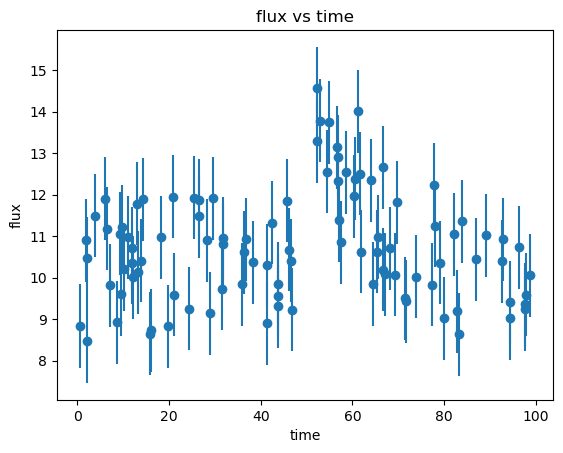

In [2]:
data = np.load('transient.npy')
plt.errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], fmt="o")
plt.xlabel('time')
plt.ylabel('flux')
plt.title('flux vs time')
plt.show()

# 2. Ploting the first function over the data
The values of the parameters are simply decided by what seems to work best, they're not decisive.


$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$ where $\alpha = 1 /2\sigma_W^2$

In [55]:
burst_t_0 =  50
burst_b = 10
burst_A = 14
burst_alpha = 0.5
init_burst = np.array([burst_t_0, burst_b, burst_A, burst_alpha])

init_gauss = np.array([burst_t_0, burst_b, 600, 1])

def burst(parameters, t):
    t_0, b, A, alpha  = parameters
    if (t < t_0): return b
    else: return b + A * np.exp(-alpha * (t - t_0))

def gauss_profile(parameters, t):
    t_0, b, A, alpha  = parameters
    return b + A * np.exp(- alpha * (t - t_0)**2)

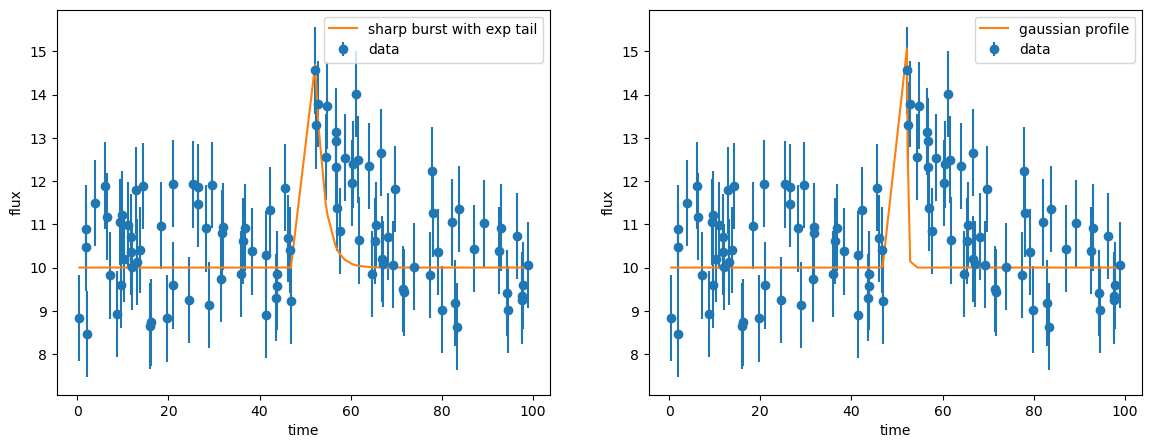

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

ax[0].errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], fmt="o", label = 'data')
y_burst = [burst(init_burst, data[i, 0]) for i in range(len(data[:, 0]))]
ax[0].plot(data[:, 0], y_burst, label = 'sharp burst with exp tail')

ax[1].errorbar(data[:, 0], data[:, 1], yerr=data[:, 2], fmt="o", label = 'data')
y_gauss = [gauss_profile(init_gauss, data[i, 0]) for i in range(len(data[:, 0]))]
ax[1].plot(data[:, 0], y_gauss, label = 'gaussian profile')

for i in range(2):
    ax[i].legend()
    ax[i].set(xlabel= 'time', ylabel = 'flux')
plt.show()

## 3. Nested sampling

In [9]:
import dynesty

ndim = 4 #dimention of the parameter space (t0, b, A, alpha)

#range of our parameters
t_0min, t_0max = 0, 100
bmin, bmax = 0,50
Amin, Amax = 0,50
alphamin, alphamax = np.exp(-5),np.exp(5)


In [81]:
import scipy

def burst(parameters, x):
    t_0, b, A, alpha = parameters
    y = []
    for i in range(len(x)):
        if (x[i] < t_0): y.append(b)
        else: y.append(b + A * np.exp (-alpha * (x[i] - t_0)))
    y = np.array(y)
    return y

def loglikelihood (parameters, data, model=burst):
    x, y, sigma_y = data.T
    
    if model == 'burst': y_fit = burst(parameters, x)
    elif model == 'gauss_profile': y_fit = gauss_profile(parameters, x)
        
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 )

#we have a uniform distribution on A, b, t0 and 1/alpha
#if we go to a log prior we have a constant in A, b and t_0 which we put to zero
#and a log(alpha)
#but what we actually need isn't the prior itself, but a function that transforms samples from the unit 4dcube to the target prior
#meaning we have a number which is distributed uniformly in 4d between 0, 1
def ptform(u, model):
    x = np.array(u)
    #t_0 = x[0] uniform in 0,100
    #b = x[1] uniform in 0,50
    #A = x[2] uniform in 0,50
    #alpha = x[3]  ln(alpha) uniform in -5, 5

    #transforming t_0:
    x[0] = scipy.stats.uniform.ppf(u[0], loc = t_0min, scale = t_0max - t_0min)

    #transforming b
    x[1] = scipy.stats.uniform.ppf(u[1], loc = bmin, scale = bmax - bmin)

    #transforming A
    x[2] = scipy.stats.uniform.ppf(u[2], loc = Amin, scale = Amax - Amin)

    #transforming alpha
    if model == 'burst':
        x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
    elif model =='gprofile':
        x[3] = scipy.stats.loguniform.ppf(u[3],sigmaWmin,sigmaWmax)
        
    return x

In [83]:
sampler = dynesty.NestedSampler(loglikelihood, ptform, ndim, logl_args=[data,'burst'],ptform_args=['burst'])
sampler.run_nested()
sresults = sampler.results

3353it [01:06, 24.06it/s, bound: 28 | nc: 62 | ncall: 38337 | eff(%):  8.746 | loglstar:   -inf < -87.254 <    inf | logz: -93.852 +/-  0.108 | dlogz: 37.829 >  0.509]      Traceback (most recent call last):
  File "C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\dynesty\dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lm101\AppData\Local\Temp\ipykernel_12912\3306725556.py", line 43, in ptform
    x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\scipy\stats\_distn_infrastructure.py", line 2249, in ppf
    place(output, cond3, argsreduce(cond3, upper_bound)[0])
  File "C:\Users\lm101\anaconda3\envs\pymc_env\Lib\site-packages\numpy\lib\function_base.py", line 1954, in place
    return _place(arr, mask, va

Exception while calling prior_transform function:
  params: [0.38718569 0.23141071 0.38807356 0.1748978 ]
  args: ['burst']
  kwargs: {}
  exception:


KeyboardInterrupt: 